In [28]:
!pip install tensorflow

Processing of the dataset 

In [1]:
import os
import shutil
import random

# Paths
source_dir = r"C:\Users\YASHRAJ\OneDrive\文档\Skribix-copy\skribix_v2\sketches"
dest_dir = r"C:\Users\YASHRAJ\Last_dataset\normalised"

# Ensure the destination directory exists
os.makedirs(dest_dir, exist_ok=True)

# Get all class folders
all_classes = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

print("Processing the images...\n")
print(f"Total classes found: {len(all_classes)}\n")

total_images_copied = 0

for idx, class_name in enumerate(sorted(all_classes), start=1):
    class_source_path = os.path.join(source_dir, class_name)
    class_dest_path = os.path.join(dest_dir, class_name)
    os.makedirs(class_dest_path, exist_ok=True)

    images = sorted(os.listdir(class_source_path))
    
    for img_name in images:
        src_path = os.path.join(class_source_path, img_name)
        dest_path = os.path.join(class_dest_path, img_name)
        shutil.copy(src_path, dest_path)
        total_images_copied += 1

    print(f"[{idx}/{len(all_classes)}] Processed '{class_name}' - {len(images)} images copied.")

print("\nDataset processing complete.")
print(f"Total classes processed: {len(all_classes)}")
print(f"Total images copied: {total_images_copied}")

Processing the images...

Total classes found: 15

[1/15] Processed 'airplane' - 80 images copied.
[2/15] Processed 'book' - 80 images copied.
[3/15] Processed 'cup' - 80 images copied.
[4/15] Processed 'envelope' - 80 images copied.
[5/15] Processed 'fan' - 80 images copied.
[6/15] Processed 'fork' - 80 images copied.
[7/15] Processed 'hat' - 80 images copied.
[8/15] Processed 'key' - 80 images copied.
[9/15] Processed 'laptop' - 80 images copied.
[10/15] Processed 'leaf' - 80 images copied.
[11/15] Processed 'moon' - 80 images copied.
[12/15] Processed 'pizza' - 80 images copied.
[13/15] Processed 't-shirt' - 80 images copied.
[14/15] Processed 'traffic light' - 80 images copied.
[15/15] Processed 'wineglass' - 80 images copied.

Dataset processing complete.
Total classes processed: 15
Total images copied: 1200


Splitting the processed dataset

In [2]:
import os
import shutil
import random

# Paths
NORMALIZED_PATH = r"C:\Users\YASHRAJ\Last_dataset\normalised"
DATASET_SPLIT_PATH = r"C:\Users\YASHRAJ\Last_dataset\split"

# Define split percentages
TRAIN_RATIO = 0.7
VAL_RATIO = 0.1
TEST_RATIO = 0.2

# Create dataset split directories
for split in ["train", "val", "test"]:
    split_path = os.path.join(DATASET_SPLIT_PATH, split)
    os.makedirs(split_path, exist_ok=True)

print("Starting dataset splitting...\n")
print(f"Split ratios - Train: {int(TRAIN_RATIO*100)}%, Validation: {int(VAL_RATIO*100)}%, Test: {int(TEST_RATIO*100)}%\n")

total_classes = 0
total_train = 0
total_val = 0
total_test = 0

# Iterate through each class
for class_name in sorted(os.listdir(NORMALIZED_PATH)):
    class_source_path = os.path.join(NORMALIZED_PATH, class_name)
    
    if not os.path.isdir(class_source_path):
        continue  # Skip non-directory files

    images = sorted(os.listdir(class_source_path))
    random.shuffle(images)

    train_count = int(len(images) * TRAIN_RATIO)
    val_count = int(len(images) * VAL_RATIO)

    train_images = images[:train_count]
    val_images = images[train_count:train_count + val_count]
    test_images = images[train_count + val_count:]

    # Update totals
    total_classes += 1
    total_train += len(train_images)
    total_val += len(val_images)
    total_test += len(test_images)

    # Copy files
    for split, split_images in zip(["train", "val", "test"], [train_images, val_images, test_images]):
        split_class_path = os.path.join(DATASET_SPLIT_PATH, split, class_name)
        os.makedirs(split_class_path, exist_ok=True)

        for img_name in split_images:
            src_img_path = os.path.join(class_source_path, img_name)
            dest_img_path = os.path.join(split_class_path, img_name)
            shutil.copy(src_img_path, dest_img_path)

    print(f"[{total_classes}] {class_name}: {len(train_images)} train, {len(val_images)} val, {len(test_images)} test")

# Summary
print("\nDataset splitting complete.")
print(f"Total classes processed: {total_classes}")
print(f"Total images -> Train: {total_train}, Validation: {total_val}, Test: {total_test}")


Starting dataset splitting...

Split ratios - Train: 70%, Validation: 10%, Test: 20%

[1] airplane: 56 train, 8 val, 16 test
[2] book: 56 train, 8 val, 16 test
[3] cup: 56 train, 8 val, 16 test
[4] envelope: 56 train, 8 val, 16 test
[5] fan: 56 train, 8 val, 16 test
[6] fork: 56 train, 8 val, 16 test
[7] hat: 56 train, 8 val, 16 test
[8] key: 56 train, 8 val, 16 test
[9] laptop: 56 train, 8 val, 16 test
[10] leaf: 56 train, 8 val, 16 test
[11] moon: 56 train, 8 val, 16 test
[12] pizza: 56 train, 8 val, 16 test
[13] t-shirt: 56 train, 8 val, 16 test
[14] traffic light: 56 train, 8 val, 16 test
[15] wineglass: 56 train, 8 val, 16 test

Dataset splitting complete.
Total classes processed: 15
Total images -> Train: 840, Validation: 120, Test: 240


Training the model

In [3]:
import os
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Paths
DATASET_SPLIT_PATH = r"C:\Users\YASHRAJ\Last_dataset\split"
MODEL_SAVE_PATH = r"C:\Users\YASHRAJ\Last_CNN\OptimizedCNN_bestepoch_model.h5"

# Parameters
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
EPOCHS = 30

#Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    shear_range=0.05
)


val_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Load datasets
print("\n Loading dataset...\n")

train_generator = train_datagen.flow_from_directory(
    os.path.join(DATASET_SPLIT_PATH, "train"),
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(DATASET_SPLIT_PATH, "val"),
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    classes=train_generator.class_indices
)

# CNN Model
print("\n Building CNN model...\n")

model = keras.Sequential([
    layers.Input(shape=(256, 256, 1)),

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(train_generator.class_indices), activation='softmax')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


# Callbacks
checkpoint_cb = ModelCheckpoint(
    filepath=MODEL_SAVE_PATH,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)

# Train
print("\n Starting training...\n")
start_time = time.time()

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb],
    verbose=1
)

end_time = time.time()
duration = end_time - start_time

# Summary
best_val_acc = max(history.history['val_accuracy'])
best_train_acc = max(history.history['accuracy'])

print("\n Training complete!")
print(f" Best Model saved at: {MODEL_SAVE_PATH}")
print(f" Best Training Accuracy: {best_train_acc * 100:.2f}%")
print(f" Best Validation Accuracy: {best_val_acc * 100:.2f}%")




 Loading dataset...

Found 840 images belonging to 15 classes.
Found 120 images belonging to 15 classes.

 Building CNN model...




 Starting training...

Epoch 1/30


27/27 [==============================] - ETA: 0s - loss: 2.7995 - accuracy: 0.0702
Epoch 1: val_accuracy improved from -inf to 0.15833, saving model to C:\Users\YASHRAJ\Last_CNN\OptimizedCNN_bestepoch_model.h5


c:\Users\Yashraj\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 28s 956ms/step - loss: 2.7995 - accuracy: 0.0702 - val_loss: 2.6980 - val_accuracy: 0.1583 - lr: 0.0010
Epoch 2/30
27/27 [==============================] - ETA: 0s - loss: 2.4548 - accuracy: 0.2024
Epoch 2: val_accuracy improved from 0.15833 to 0.50833, saving model to C:\Users\YASHRAJ\Last_CNN\OptimizedCNN_bestepoch_model.h5
27/27 [==============================] - 23s 844ms/step - loss: 2.4548 - accuracy: 0.2024 - val_loss: 1.6303 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 3/30
27/27 [==============================] - ETA: 0s - loss: 1.9106 - accuracy: 0.4143
Epoch 3: val_accuracy improved from 0.50833 to 0.57500, saving model to C:\Users\YASHRAJ\Last_CNN\OptimizedCNN_bestepoch_model.h5
27/27 [==============================] - 23s 881ms/step - loss: 1.9106 - accuracy: 0.4143 - val_loss: 1.2522 - val_accuracy: 0.5750 - lr: 0.0010
Epoch 4/30
27/27 [==============================] - ETA: 0s - loss: 1.4645 - accuracy: 0.5286
Epoch 4: val_accuracy i

Testing the model on test dataset

In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# Paths
DATASET_SPLIT_PATH = r"C:\Users\YASHRAJ\Last_dataset\split"
MODEL_SAVE_PATH = r"C:\Users\YASHRAJ\Last_CNN\OptimizedCNN_bestepoch_model.h5"

# Parameters
IMG_SIZE = (256, 256)
BATCH_SIZE = 32

# Load the trained model
print("\n Loading saved model...\n")
model = load_model(MODEL_SAVE_PATH)

# Test data generator (only rescaling)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Load test data
print(" Loading test dataset...\n")

test_generator = test_datagen.flow_from_directory(
    os.path.join(DATASET_SPLIT_PATH, "test"),  # make sure 'test' folder exists
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False  # important for matching predictions to filenames
)

# Evaluate the model
print("\n Evaluating on test set...\n")
loss, accuracy = model.evaluate(test_generator, verbose=1)

print(f"\n  Test Accuracy: {accuracy * 100:.2f}%")
print(f"  Test Loss: {loss:.4f}")





 Loading saved model...

 Loading test dataset...

Found 240 images belonging to 15 classes.

 Evaluating on test set...

8/8 [==============================] - 4s 571ms/step - loss: 0.8343 - accuracy: 0.8042

  Test Accuracy: 80.42%
  Test Loss: 0.8343


Evaluating the model on some random images

1/1 [==============================] - 0s 30ms/step


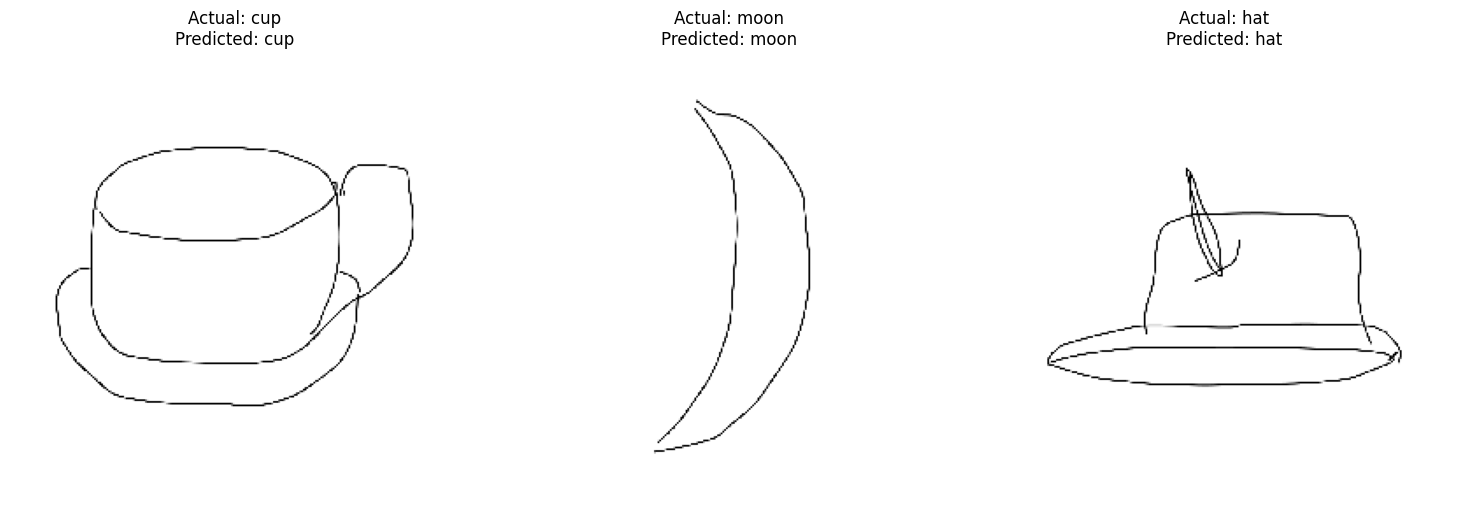

In [8]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Paths
MODEL_SAVE_PATH = r"C:\Users\YASHRAJ\Last_CNN\OptimizedCNN_bestepoch_model.h5"
TEST_DIR = r"C:\Users\YASHRAJ\Last_dataset\split\test"

# Parameters
IMG_SIZE = (256, 256)

# Load model
model = load_model(MODEL_SAVE_PATH)

# Map class indices to labels
class_indices = {}
for class_name in sorted(os.listdir(TEST_DIR)):
    class_indices[class_name] = len(class_indices)
index_to_class = {v: k for k, v in class_indices.items()}

# Select 3 random samples from different classes
selected_samples = []
class_folders = os.listdir(TEST_DIR)
random.shuffle(class_folders)

for class_name in class_folders:
    class_path = os.path.join(TEST_DIR, class_name)
    if os.path.isdir(class_path) and len(os.listdir(class_path)) > 0:
        image_file = random.choice(os.listdir(class_path))
        image_path = os.path.join(class_path, image_file)
        selected_samples.append((image_path, class_name))
    if len(selected_samples) == 3:
        break

# Plot predictions
plt.figure(figsize=(15, 5))

for i, (image_path, actual_class) in enumerate(selected_samples):
    img = image.load_img(image_path, color_mode="grayscale", target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = index_to_class[np.argmax(prediction)]

    plt.subplot(1, 3, i + 1)
    plt.imshow(np.array(img).squeeze(), cmap='gray')
    plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}")
    plt.axis('off')

plt.tight_layout()
plt.show()
